In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter
    <a href=\"https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/\">extensions</a>.
</div>

# SIRD parameter learning using GD with Tikhonov regularisation

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [0,1]^3} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2 + \frac{\theta}{2} \|\alpha\|^2,
\end{align}
where $\rho = (\begin{smallmatrix} S & I & R \end{smallmatrix})$ comes from the solution of the traditional forward Susceptibles, Infected, and Recovered (SIR) model, and $\widehat{\rho}$ is a target and known state. The regularisation parameter $\theta$ is non negative. We will study the effect of this parameter on the choice of the control pair $\alpha$.
    
For each triplet of parameters $\alpha = (\beta, \gamma,m) \in [0,1]^3$ corresponding to the transmission and the recovery rates, the three variables $S(t)$, $I(t)$, and $R(t)$ are governed by the following differential equations
    
\begin{align}
    \frac{\dif S}{\dif t} &= -\beta S I,
    \\
    \frac{\dif I}{\dif t} &= \beta S I - (\gamma+m) I,
    \\
    \frac{\dif R}{\dif t} &= \gamma I.
\end{align}
    
We note that $S + I + R = n$, where $n$ is the total population. 
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, ones, allclose, arctan, exp, pi, append, arange
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals
from scipy.integrate import simpson
from scipy.optimize  import minimize, Bounds
from scipy.interpolate import CubicHermiteSpline
from numpy.polynomial.chebyshev import chebpts1
from matplotlib import colormaps

# Problem setup

Initial conditions:

In [4]:
# Total population
n = 400
# Initial conditions
f = 5e-2
Sₒ, Iₒ, Rₒ = (1-f)*n, f*n, 0.0    # These are for reference, changing them won't affect the later code

## Generation of $\widehat \rho$

We are going to generate a choice for $\widehat\rho$ based on a solution of the system that satisfies the initial condition. For this, we find $\widehat\rho_{\mathsf e}$ as the solution of the SIR model for the choice $\alpha = (0.01,0.5)$. Then we compute the smooth transformation $p_1 = \widehat{\rho}_{\mathsf e} + 4 \big(\sin(\widehat{\rho}_{\mathsf e}) - \sin(\rho_0) \big)$.

In [5]:
T  = 3                             # Final time
Tₑ = 0.5*(chebpts1(200)+1) * T     # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])     # Add endpoints

In [6]:
# Rates for ρ̂ₑ:
βₑ, γₑ, mₑ = 0.007, 0.1, 0.05
αₑ = asarray([βₑ, γₑ, mₑ])

In [7]:
print('Basic reproduction number:', n*βₑ/(γₑ+mₑ))

Basic reproduction number: 18.666666666666664


In [8]:
def SIRD(t, z, β,γ,m):
    S, I, R = z
    return [-β*S*I, β*S*I - γ*I - m*I, γ*I]

In [9]:
sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=(βₑ, γₑ, mₑ), t_eval = Tₑ, dense_output=True, vectorized=True)
print(sol['message'])

The solver successfully reached the end of the integration interval.


In [10]:
ρ̂ₑ  = sol.y;    ρ = ρ̂ₑ.copy()
dρ̂ₑ = asarray(SIRD(0,ρ̂ₑ,βₑ,γₑ,mₑ))

Apply smooth transformation:

In [11]:
p_1 = ρ̂ₑ + 4*sin(ρ̂ₑ) - 4*sin(ρ̂ₑ[:,0])[::,np.newaxis]

Now we split the integral $[0,T]$ into $k$ periods and compute the rolling average of $p_1$ on each subinterval yielding a vector:
\begin{align*}
    (p_2)_i = \int\limits_{t_{i}}^{t_{i+1}} \frac{p_1}{t_{i+1} - t_i} \, \mathrm{d} s  \qquad \qquad \forall i \in [0:k-1].
\end{align*}

In [12]:
from scipy.integrate import quad_vec

In [13]:
SmoothVar = lambda t: sol.sol(t) + 4 * sin(sol.sol(t) - 4 * sin(ρ̂ₑ[:,0]) )

In [14]:
num_subintervals = 50
t_values = np.linspace(0, T, num_subintervals + 1)

In [15]:
IntQUADPACK = [quad_vec(SmoothVar, t_values[i], t_values[i+1], full_output=False)   for i in range(num_subintervals)]
averages    = asarray([IntQUADPACK[i][0]    for i in range(num_subintervals)]) / ( t_values[1] - t_values[0] )
print('Maximum integration error estimate: {0:.2e}'.format(asarray([IntQUADPACK[i][1]    for i in range(num_subintervals)]).max()) )

Maximum integration error estimate: 8.97e-09


Now let's keep monotony of the function: (a) susceptibles cannot increase, (b) recovered cannot decrease, (c) infected cannot decrease until the peak is reached.

In [16]:
MonAv = averages.copy()
for i in range(1,num_subintervals):
    # Susceptible
    if MonAv[i,0] > MonAv[i-1,0]:
        MonAv[i,0] = MonAv[i-1,0]
    # Recovered
    if MonAv[i,2] < MonAv[i-1,2]:
        MonAv[i,2] = MonAv[i-1,2]
    # Infected
    idx_cut = np.digitize(Tₑ[np.argmax(ρ̂ₑ.T[:,1])], t_values) - 1    # Compute maximal increase (based on original smooth curve)
    if i <= idx_cut:
        if MonAv[i,1] < MonAv[i-1,1]:
            MonAv[i,1] = MonAv[i-1,1]
    else:
        if MonAv[i,1] > MonAv[i-1,1]:
            MonAv[i,1] = MonAv[i-1,1]

Now produce an upper semicontinuous function from the average:
\begin{align*}
    \hat{\rho} = p_3(t) = \sum_{i=0}^{k-1} (p_2)_i \iota_{ t_{i+1} \leq t < t_i  } + (p_2)_{k-1} \iota_{t=T}.
\end{align*}

In [17]:
def averaged_ρ(t):
    # Ensure t is within the defined interval
    if np.any(t < 0) or np.any(t > T):
        raise ValueError("Some t values are out of bounds!")
    
    # Find the subinterval index:
    idx = np.digitize(t, t_values) - 1
    
    # Handle the edge case where t == T
    idx = np.where(t == T, len(MonAv) - 1, idx)
    
    return MonAv[idx].T

In [18]:
ρ̂ = averaged_ρ(Tₑ)
ρ̄ = averaged_ρ      # Functional representation

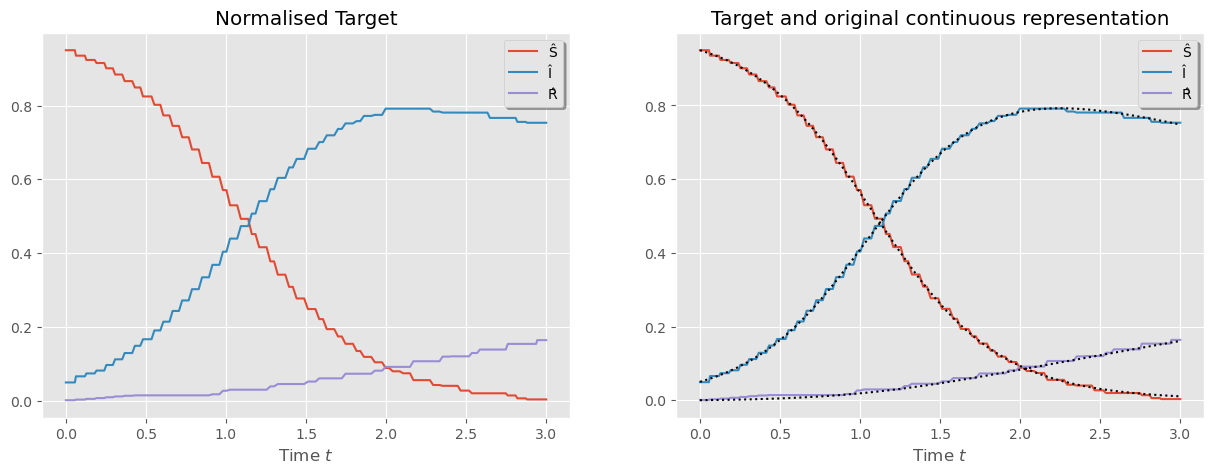

In [19]:
# Plot Target curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ̂.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['Ŝ', 'Î', 'R̂'], shadow=True)
plt.title('Normalised Target')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, ρ̂.T/n)
plt.plot(Tₑ, ρ̂ₑ.T/n, ':', c='black', linewidth=1.5)
plt.xlabel(r'Time $t$')
plt.legend(['Ŝ', 'Î', 'R̂'], shadow=True)
plt.title('Target and original continuous representation')
plt.show()

## Create a given state

In [20]:
# Give a random initial control
α = asarray([0.01,0.02,0.1])

In [21]:
# Compute state ρ(α)
ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                  dense_output=True, vectorized=True)
if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
ρ = ρ_sol.y

# Create an abstract interpolator for state
ρₜ = ρ_sol.sol    # CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)

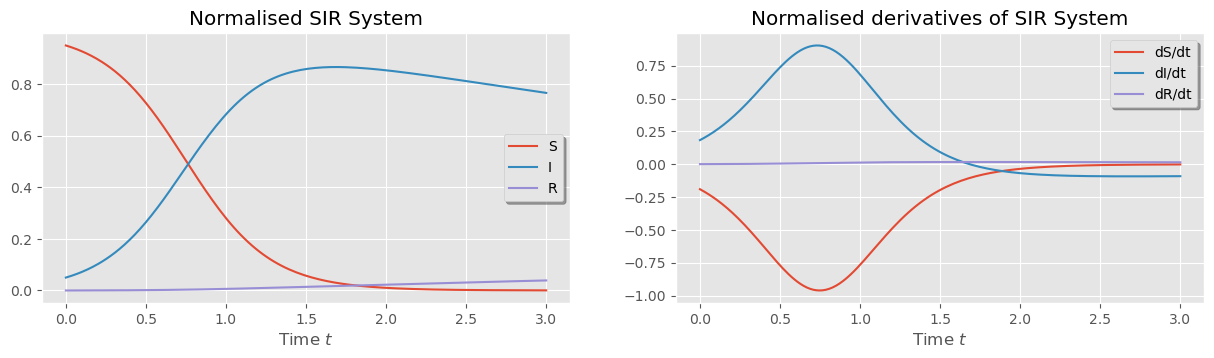

In [22]:
# Plot SIR curves
plt.figure(figsize=(15,3.5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.title('Normalised SIR System')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, asarray(SIRD(0.0, ρ, α[0], α[1], α[2])).T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dS/dt', 'dI/dt', 'dR/dt'], shadow=True)
plt.title('Normalised derivatives of SIR System')
plt.show()

## Adjoint system

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_S}{\dif t} &= \hat{S} - S +\beta I(q_S - q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I + \beta S(q_S - q_I) + \gamma (q_I - q_R) + m q_I,
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
\end{align}
with the terminal condition $q(T) = 0$.

Let us see how we can implement this with an adaptive step method:

In [23]:
def Adjoint(t, z, β,γ,m, ρ):
    S̄, Ī, R̄ = ρ̄(t)    # Target
    S, I, R = ρ(t)     # State
    qₛ, qᵢ, qᵣ = z     # Adjoint
    return [S̄ - S + β*I*(qₛ - qᵢ), Ī - I + β*S*(qₛ - qᵢ) + γ*(qᵢ - qᵣ) + m*qᵢ, R̄ - R]

Let us try solving this problem for $\rho = \widehat{\rho}$:

In [24]:
solₛ = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(0.1, 0.01,0.1, ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 446 function evaluations.


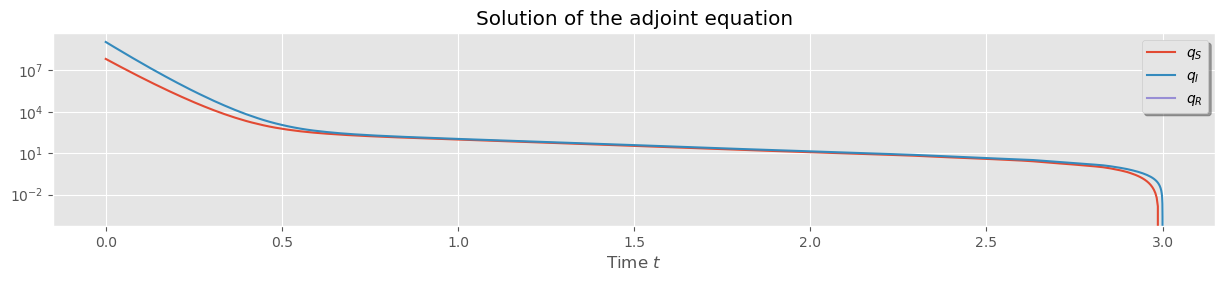

In [25]:
# Plot adjoint curves
plt.figure(figsize=(15,2.5))
plt.plot(Tₑ[::-1],solₛ.y.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
plt.title('Solution of the adjoint equation')
plt.yscale('log')
plt.show()

Now we try to optimise the function
\begin{align}
    f(\alpha) = \frac{1}{2} \int\limits_0^T \big( S(t) - \hat{S}(t) \big)^2 + \big( I(t) - \hat{I}(t) \big)^2 + \big( R(t) - \hat{R}(t) \big)^2 \,\dif t + \frac{\theta}{2} ( \beta^2 + \gamma^2 +m^2 ).
\end{align}

In [26]:
def Objective(ρ,ρ̂,α, θ):    return 0.5 * (simpson((ρ-ρ̂)**2,x=Tₑ).sum() + θ * (α**2).sum())

In [27]:
def proj(α):    return minimum(maximum(α,0.0),1.0)

In [28]:
print('As an example, the distance between ρ and ρ̂ is {0:.4f}.'.format( Objective(ρ,ρ̂,α,1e+3) ))

As an example, the distance between ρ and ρ̂ is 11594.7031.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} = \int\limits_0^T S I( q_I - q_S ) \, \dif t + \theta \beta,
    \qquad
    \frac{\partial f}{\partial \gamma} = \int\limits_0^T I( q_R - q_I ) \, \dif t  + \theta \gamma,
    \qquad
    \frac{\partial f}{\partial m} = \int\limits_0^T -I q_I  \, \dif t  + \theta m. 
\end{align}

In [29]:
q = solₛ.y[:,::-1]

In [30]:
θ = 0.1
df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), simpson(ρ[1] * (q[2]-q[1]), x=Tₑ), -simpson(ρ[1] * q[1], x=Tₑ)])  + θ * α
display(df.tolist())

[251759367575.16516, -716288666.3496727, -716259675.1077482]

# Surfaces

We can observe what happens with the cost functional for different values of the hyperparameter $\alpha$:

In [31]:
θ = 0.0

In [32]:
global ρ, q
ρ = np.zeros_like(ρ̂)
q = np.zeros_like(ρ̂)

In [33]:
def obj_eval_a(α):                # ** Eval just j ** #
    global ρ
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α, θ*(n**2) if scaling else θ )
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)
def obj_eval(α):                  # ** Eval j and j' ** #
    global ρ, q
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIRD, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α, θ*(n**2) if scaling else θ )
    f /= (n**2) if scaling else 1.0
    
    # Create an abstract interpolator for state
    #ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1],α[2])), axis=-1)
    # Alternative from ODE struct: 
    ρₜ = ρ_sol.sol
    
    # Compute adjoint
    q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(α[0], α[1], α[2], ρₜ), t_eval = Tₑ[::-1], dense_output=False, vectorized=False)
    q = q_sol.y[:,::-1]

    # Compute derivative
    df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), simpson(ρ[1] * (q[2]-q[1]), x=Tₑ), -simpson(ρ[1] * q[1], x=Tₑ)])
    df /= (n**2) if scaling else 1.0
    df += (θ * α)
    
    return asarray(f), df

In [34]:
# Optimal point should be around
# 0.007, 0.7, 0.3
# So we evaluate around this point

In [42]:
# Coarse evaluations (takes a long time)
nβ, nγ, nm = 41, 41, 31
Misfit = zeros([nβ, nγ, nm])
β_axis = linspace(0.001,0.15,nβ)
γ_axis = linspace(0.1,1,nγ)
m_axis = linspace(0.1,1,nm)
for (i,β) in enumerate(β_axis):
    #print(i)
    for (j,γ) in enumerate(γ_axis):
        for (k,m) in enumerate(m_axis):
            Misfit[i,j,k] = obj_eval_a( asarray([β,γ,m]) ).item()

In [43]:
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)
M_0, β_0, γ_0, m_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]],    m_axis[i_0[2]]
print('Smallest objective found in the mesh: {0:.4e} with (β,γ,m): ({1:.4f},{2:.4f},{3:.4f})'.format(M_0,β_0,γ_0, m_0))

Smallest objective found in the mesh: 4.6178e-02 with (β,γ,m): (0.0084,0.6175,0.5200)


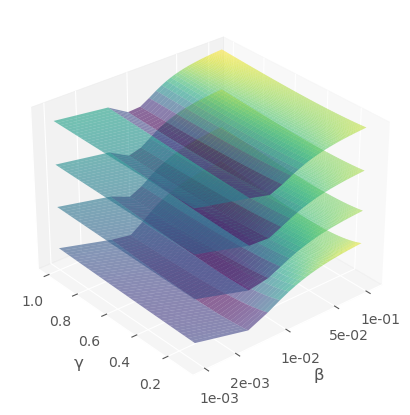

In [44]:
# Create grid of (β,γ)
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')

# Create a 3D plot
fig = plt.figure( figsize=(5, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot surfaces for each z value
for k in [0,10,20,30]:
    # Create a surface plot for each z value and stack them vertically
    ax.plot_surface(np.log(X_c), Y_c, Misfit[:,:,k]+k/10, cmap='viridis', alpha=0.6)

# Set axis labels and title
ax.set_xlabel('β')
ax.set_ylabel('γ')

#ax.set_zlabel('Z (graphically scaled)')
#ax.set_title('Stacked Surface Plots for varying $m$')

ax.view_init(elev=30, azim=230)
ax.set_box_aspect((2, 2, 1.5))

# Set the ticks
ax.set_xticks([-6.9,-6,-4.5,-3,-2]);    #ax.set_yticks([-2.3,-1.5,-0.5,0])
ax.set_xticklabels([f'{val:.0e}' for val in np.exp(ax.get_xticks())])
#ax.set_yticklabels([f'{val:.0e}' for val in np.exp(ax.get_yticks())])
ax.set_zticks([])
ax.set_facecolor('xkcd:white')
plt.show()

# Solving the optimisation problem

### Misfit with $\widehat{\rho}$

We will use a gradient-based algorithm for optimising $f$.

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Projected Gradient Descent Algorithm</h2>
<ol>
<li>Let $\alpha_0 \in [0,1]^3$ and $\eta > 0$.</li>
<li>For $k \in \{0,\ldots\}$, do
<ol>
<li>Compute state $\rho_{\alpha_k}$
<li>Compute adjoint $q_{\alpha_k}$
<li>Evaluate the gradient of the reduced functional $d_k := \nabla f(\alpha_k)$
<li>Compute $u = \alpha_{k} - \eta d_k$
<li>If $u \notin [0,1]^3$ or $f(u)> f(\alpha_k)$
<ol>
<li>Backtrack $u$ with respect to $\eta$:</li>
    <ol>
<li> $\eta = \eta \, /\, 10$</li>
<li> Set $u = \mathcal{P}_{[0,1]^3}(\alpha_{k} - \eta d_k)$</li>
<li> Stop whenever $f(u) < f(\alpha_k)$</li>
    </ol>
</ol>
    Else: $\alpha_{k+1} = u$</li>
</ol>
</li>
</ol>
</div>

Let's select a initial point at random:

In [35]:
# Initial point
β, γ, m = α = rng(80).uniform(0,1,3)
α[0] *= 0.1
α, γ + m

(array([0.07364913, 0.0184188 , 0.03663371]), 0.05505250620295099)

In [36]:
θ = 0.0
obj_eval_a(α)

array(0.63726528)

We will scale $\rho$ and $\widehat{\rho}$ by $n$.

In [37]:
def box_scale(x,y):
    '''
        Return minimum value of scalar s > 0  such that x + sy ∈ [0,1] for x ∈ [0,1]
    '''
    a = np.divide(x, y, where=(y>0))[y>0]
    b = np.divide((x-1), y, where=(y<0))[y<0]
    if len(a) > 0:
        if len(b) > 0:
            return min( a.min(), b.min() )
        else:
            return a.min()
    else:
        return b.min()

In [38]:
def GD_Algorithm(α, iters, save_iter = False, critical = 1, εₐ = 1e-9, εᵦ = 1e-16):
    '''
        Create structures to store information from iterates
    '''
    every_iter = {
        'it':[], 'obj':[], 'time':[], 'β':[], 'γ':[], 'm':[], 'df_β':[], 'df_γ':[], 'df_m':[],
        'norms':{'ℓ_1': [], 'ℓ_2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'time':[], '|df|_2':[], '|df|_max':[]}
    
    '''
        GD iterates
    '''
    print('     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  ')
    print( '{:–^62}'.format('') )
    
    β, γ, m = α
    timed = 0.0
    for k in range(iters):
        it_time = time.time()
        
        # Compute state, adjoint, and derivative (ρ and q are global variables)
        f, df = obj_eval(α)
        
        # Create scale factor is derivative is too far away from [0,1]^3:
        # In other words: go one step ahead if α - s * df goes too far, backtracking will waste time!
        bₜ = box_scale(α,df)
        s  = 0.5/norm(df) if norm(df,np.inf) > 1.0 else 1.0
        s = s if bₜ <= 0.0 else max(bₜ,s)
        #s  = 1/norm(df) if norm(df,np.inf) > 1.0 else 1.0 # This is bad
        
        # Find new step
        for η in 10**-linspace(0,40,41):
            #u = proj(α - η*df/norm(df))
            u = proj(α - η*s*df)
            fₖ = obj_eval_a(u)
            if fₖ < f :#- 10**4 * η * df.dot(df)/norm(df):
                break
            
                
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        if save_iter:
            every_iter['it'].append( k-1 )
            every_iter['obj'].append( f )
            every_iter['time'].append( timed )
            every_iter['β'].append( α[0] )
            every_iter['γ'].append( α[1] )
            every_iter['m'].append( α[2] )
            every_iter['df_β'].append( df[0] )
            every_iter['df_γ'].append( df[1] )
            every_iter['df_m'].append( df[2] )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(df)/(3**0.5) )
            every_iter['norms']['ℓ_1'].append( (1/3) * norm(df,1) )
            every_iter['norms']['max'].append( norm(df,np.inf) )
            every_iter['norms']['min'].append( abs(df).min() )
        
        if k % critical == 0:
            every_critical['it'].append( k )
            every_critical['obj'].append( f )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(df)/(3**0.5) )
            every_critical['|df|_max'].append( norm(df,np.inf) )
            
            print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(k,
                                                                        f, timed,
                                                                        norm(df)/(3**0.5), 
                                                                        norm(df,np.inf) ))
            
        # Update step
        v = α.copy()
        α = u
        β, γ, m = α
        
        ρ = ρ_sol.y
        
        if abs(f - fₖ) < εᵦ:
            print('|fₖ - f| < {0:1.0e}'.format(εᵦ))
            print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(k,
                                                                        f,
                                                                        timed,
                                                                        norm(df)/(3.0**0.5), 
                                                                        norm(df,np.inf) ))
            break
        
        f = fₖ
        
        if norm(α - v)/(3.0**0.5) < εₐ:
            print('‖αₖ - u‖ < {0:1.0e}'.format(εₐ))
            print(α)
            print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(k,
                                                                        f,
                                                                        timed,
                                                                        norm(df)/(3**0.5), 
                                                                        norm(df,np.inf) ))
            break
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    return α, ρ, every_critical, every_iter

In [39]:
ᾱ, ρ, every_critical, every_iter = GD_Algorithm(α, 10000, 
                                                    save_iter = True, critical = 1, εₐ = 1e-13, εᵦ = 1e-13)

     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  6.4e-01 |     0.04  | 1.168e+00   |   1.519e+00  
*      1 |  4.9e-01 |     0.06  | 3.514e+00   |   6.045e+00  
*      2 |  4.5e-01 |     0.09  | 4.634e+00   |   7.995e+00  
*      3 |  4.1e-01 |     0.14  | 6.312e+00   |   1.091e+01  
*      4 |  3.4e-01 |     0.15  | 8.903e+00   |   1.541e+01  
*      5 |  2.5e-01 |     0.16  | 1.332e+01   |   2.305e+01  
*      6 |  1.1e-01 |     0.17  | 1.833e+01   |   3.174e+01  
*      7 |  1.1e-02 |     0.20  | 1.124e+01   |   1.947e+01  
*      8 |  6.2e-03 |     0.21  | 4.726e+00   |   8.183e+00  
*      9 |  5.1e-03 |     0.25  | 1.955e+00   |   3.381e+00  
*     10 |  4.8e-03 |     0.28  | 8.333e-01   |   1.432e+00  
*     11 |  4.8e-03 |     0.29  | 9.581e-01   |   1.647e+00  
*     12 |  4.8e-03 |     0.31  | 2.862e-01   |   4.561e-01  
|fₖ - f| < 1e-13
*     12 |  4.8e-03 |     0.31  | 2.862e-01   |   4.

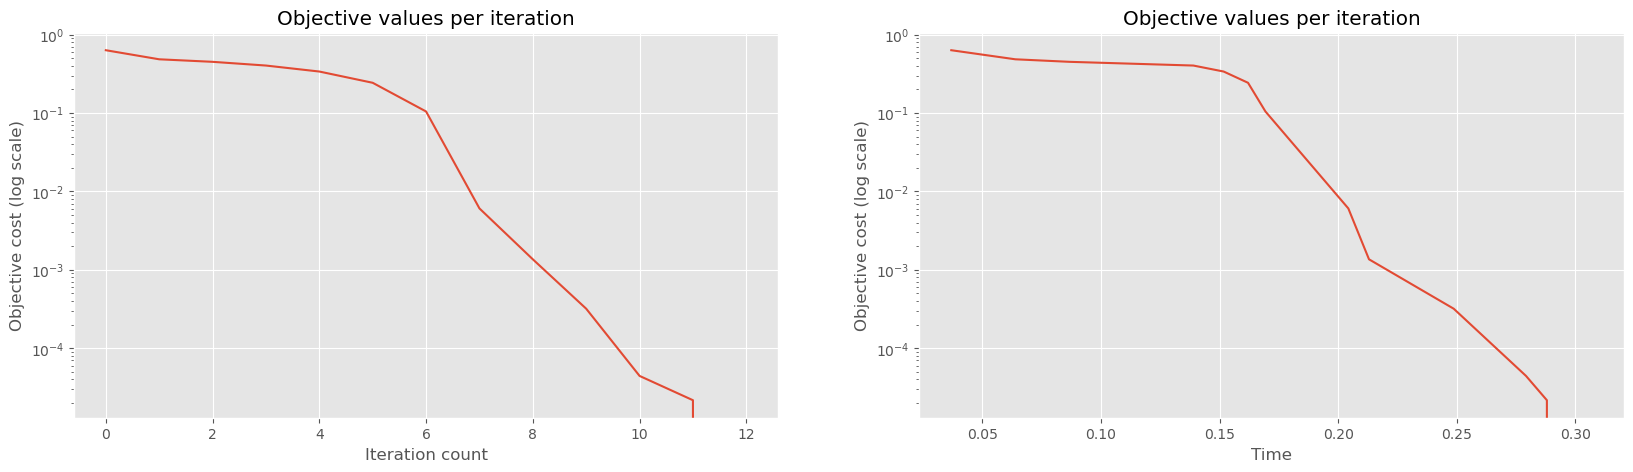

In [40]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['obj'] - min(every_iter['obj']))
plt.yscale('log');    
plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(every_iter['time'],every_iter['obj'] - min(every_iter['obj']))
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [41]:
#Regularisers = concatenate( ([0.0], 10.0 ** arange(-7,6), 5 * 10.0 ** arange(-7,5)) )
Regularisers = concatenate( ([0.0], 10.0 ** arange(-7,1)) )
Regularisers.sort()
Regularisers

array([0.e+00, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00])

In [42]:
Stats  = None
States = dict()

for θ in Regularisers:
    # Run algorithm
    print('–'*20, '{0:.0e}'.format(θ), '–'*20, '\n\n')
    ᾱ, ρ, every_critical, every_iter = GD_Algorithm(α, 10000, save_iter = True, critical = 10, εₐ = 1e-13, εᵦ = 1e-13);
    #ᾱ, ρ, every_critical, every_iter = FISTA(α, 10000, save_iter = True, critical = 100, εₐ = 1e-7, εᵦ = 1e-10,try_TR = False)
    

    # Recover dataframe from results
    every_iter['obj'] = asarray(every_iter['obj'])
    #df_every = pd.DataFrame.from_dict(every_iter)
    df_every = pd.concat([
                    pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                    pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
    #display(df_every.tail())
    #
    #df_every.to_pickle('Tests/Exact – PGD - Every.pkl') # To read back use pd.read_pickle(file_name)
    
    
    # Store info from iterate with smallest objective
    Out_θ = df_every.tail(1).rename(index={df_every.tail(1)['it'].index.values.item():θ}).copy()
    
    #df_every.tail(1).rename(index={df_every.tail(1)['it'].index.values.item():N}).copy()
    Stats = pd.concat([Stats,Out_θ])
    States[θ] = ρ.copy()

–––––––––––––––––––– 0e+00 –––––––––––––––––––– 


     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  6.4e-01 |     0.04  | 1.168e+00   |   1.519e+00  
*     10 |  4.8e-03 |     0.25  | 8.333e-01   |   1.432e+00  
|fₖ - f| < 1e-13
*     12 |  4.8e-03 |     0.28  | 2.862e-01   |   4.561e-01  

Algorithm stopped after 0.2785 seconds and 12 iterations
–––––––––––––––––––– 1e-07 –––––––––––––––––––– 


     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  6.4e-01 |     0.01  | 1.168e+00   |   1.519e+00  
*     10 |  4.8e-03 |     0.21  | 7.982e-01   |   1.371e+00  
|fₖ - f| < 1e-13
*     12 |  4.8e-03 |     0.25  | 3.431e-01   |   5.615e-01  

Algorithm stopped after 0.2527 seconds and 12 iterations
–––––––––––––––––––– 1e-06 –––––––––––––––––––– 


     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  
–––––––––––––

---

In [43]:
#CMap = get_cmap('Wistia')
CMap = colormaps['YlOrBr']
colours_GD = CMap(linspace(0.3,1,Stats.shape[0]))

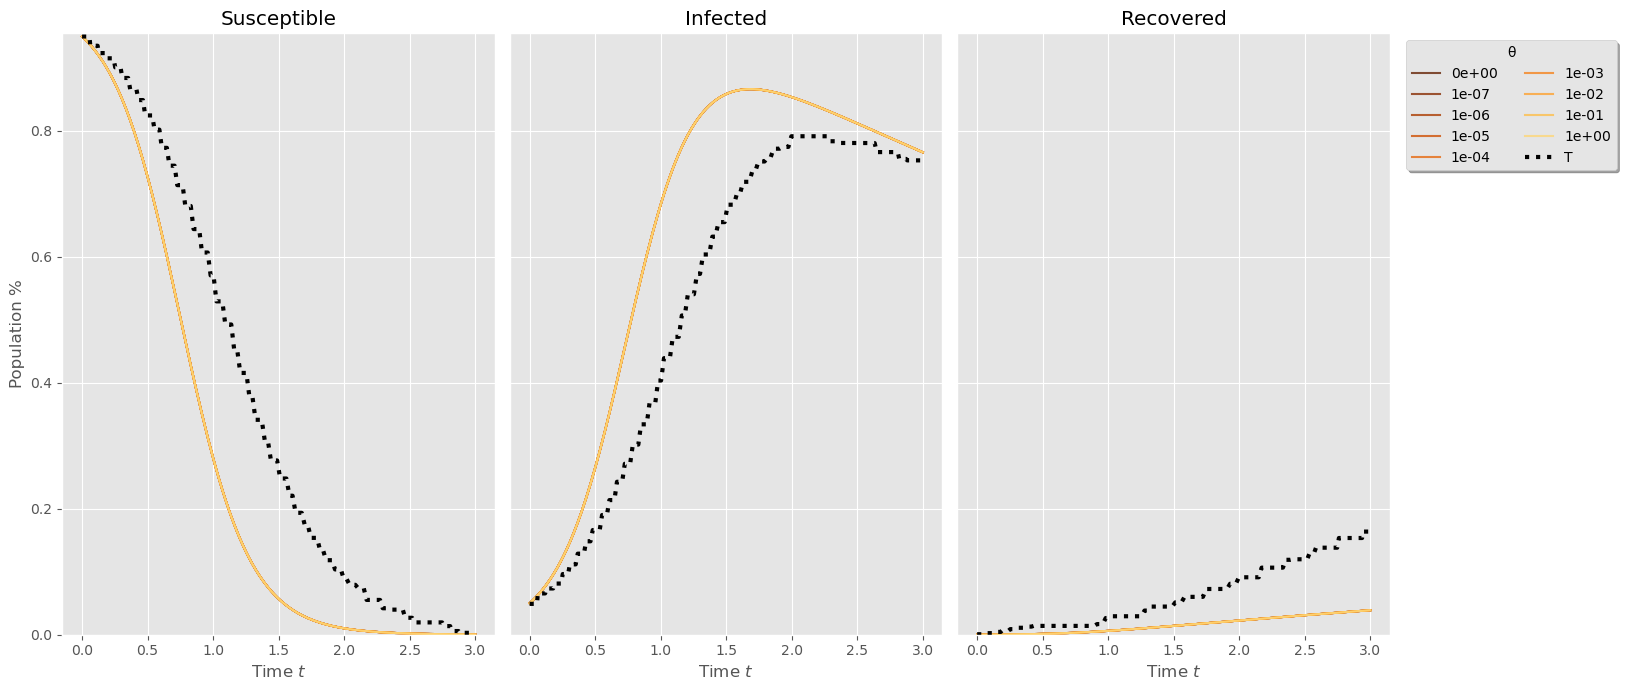

In [44]:
# Multiplot
fig, ax = plt.subplots(1, 3, figsize=(16, 7))
ax[1].set_yticklabels([]);
ax[2].set_yticklabels([]);
for tick in ax[1].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
for tick in ax[2].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    '''tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)'''

k = colours_GD.shape[0] - 1
for θ, ρ in States.items():
    
    # Susceptible
    ax[0].plot(Tₑ, ρ[0]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Infected
    ax[1].plot(Tₑ, ρ[1]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Recovered
    ax[2].plot(Tₑ, ρ[2]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    k -= 1
    
# Add target
ax[0].plot(Tₑ, ρ̂[0]/n, ':', c='black', linewidth=3, label = 'T')
ax[1].plot(Tₑ, ρ̂[1]/n, ':', c='black', linewidth=3, label = 'T')
ax[2].plot(Tₑ, ρ̂[2]/n, ':', c='black', linewidth=3, label = 'T')

ax[0].set_ylim([0.0, (Sₒ+2)/n]);    ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_ylim([0.0, (Sₒ+2)/n]);    ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_ylim([0.0, (Sₒ+2)/n]);    ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')

ax[0].set_ylabel('Population %')

plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
plt.savefig('Outputs/Regularisation – States – PGD.pdf', bbox_inches='tight', pad_inches=0)

[]

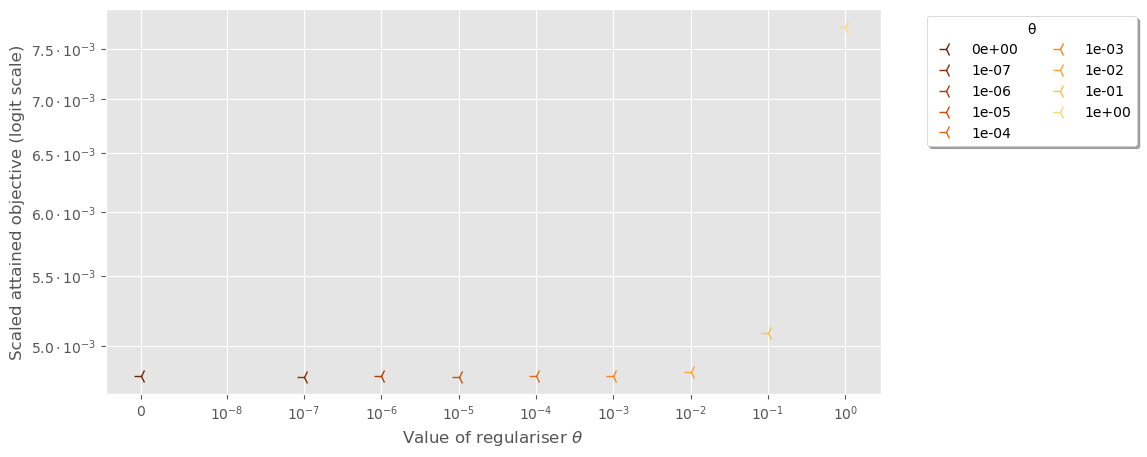

In [45]:
# Plot objective against θ
plt.figure(figsize=(10,5))

k = colours_GD.shape[0] - 1
for θ, fᵥ in Stats['obj'].items():
    
    # Susceptible
    plt.plot(θ, fᵥ, color = colours_GD[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='3', linestyle = '', markersize=10, 
             label = '{0:.0e}'.format(θ))
    
    k -= 1
    
    
plt.xscale('symlog', linthresh = 1e-8)
plt.yscale('logit')
plt.legend(bbox_to_anchor=(1.34, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')

plt.xlabel(r'Value of regulariser $\theta$');    plt.ylabel('Scaled attained objective (logit scale)')
plt.plot()

---

In [46]:
Stats

,it,obj,time,β,γ,m,df_β,df_γ,df_m,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0.000000e+00,11,0.004794,0.278489,0.006795,0.045854,0.058053,0.456078,-0.179092,-0.075108,0.236760,0.286195,0.456078,0.075108
1.000000e-07,11,0.004793,0.252664,0.006796,0.045860,0.058058,0.561514,-0.179351,-0.075404,0.272090,0.343099,0.561514,0.075404
1.000000e-06,11,0.004794,0.235712,0.006796,0.045854,0.058053,0.465031,-0.179129,-0.075148,0.239769,0.290969,0.465031,0.075148
1.000000e-05,11,0.004792,0.249170,0.006796,0.045861,0.058060,0.590227,-0.179462,-0.075524,0.281738,0.358831,0.590227,0.075524
1.000000e-04,11,0.004795,0.234607,0.006795,0.045853,0.058052,0.440962,-0.179027,-0.075036,0.231675,0.278166,0.440962,0.075036
1.000000e-03,11,0.004795,0.249935,0.006795,0.045862,0.058060,0.516169,-0.179192,-0.075230,0.256864,0.318434,0.516169,0.075230
1.000000e-02,12,0.004822,0.279827,0.006794,0.045854,0.058046,0.723174,-0.179520,-0.075487,0.326060,0.432399,0.723174,0.075487
1.000000e-01,27,0.005089,0.360958,0.006802,0.045789,0.057926,2.541634,-0.182027,-0.076776,0.933479,1.471839,2.541634,0.076776
1.000000e+00,12,0.007728,0.211248,0.006767,0.044791,0.056617,0.357528,-0.139063,-0.021845,0.172812,0.221842,0.357528,0.021845


In [47]:
Stats.to_pickle('Outputs/Regularisation – PGD - Final.pkl') # To read back use pd.read_pickle(file_name)

---

In [48]:
Stats['obj'] = np.asarray(Stats['obj'].to_list())

In [49]:
np.around(Stats,6)

,it,obj,time,β,γ,m,df_β,df_γ,df_m,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0.000000e+00,11,0.004794,0.278489,0.006795,0.045854,0.058053,0.456078,-0.179092,-0.075108,0.236760,0.286195,0.456078,0.075108
1.000000e-07,11,0.004793,0.252664,0.006796,0.045860,0.058058,0.561514,-0.179351,-0.075404,0.272090,0.343099,0.561514,0.075404
1.000000e-06,11,0.004794,0.235712,0.006796,0.045854,0.058053,0.465031,-0.179129,-0.075148,0.239769,0.290969,0.465031,0.075148
1.000000e-05,11,0.004792,0.249170,0.006796,0.045861,0.058060,0.590227,-0.179462,-0.075524,0.281738,0.358831,0.590227,0.075524
1.000000e-04,11,0.004795,0.234607,0.006795,0.045853,0.058052,0.440962,-0.179027,-0.075036,0.231675,0.278166,0.440962,0.075036
1.000000e-03,11,0.004795,0.249935,0.006795,0.045862,0.058060,0.516169,-0.179192,-0.075230,0.256864,0.318434,0.516169,0.075230
1.000000e-02,12,0.004822,0.279827,0.006794,0.045854,0.058046,0.723174,-0.179520,-0.075487,0.326060,0.432399,0.723174,0.075487
1.000000e-01,27,0.005089,0.360958,0.006802,0.045789,0.057926,2.541634,-0.182027,-0.076776,0.933479,1.471839,2.541634,0.076776
1.000000e+00,12,0.007728,0.211248,0.006767,0.044791,0.056617,0.357528,-0.139063,-0.021845,0.172812,0.221842,0.357528,0.021845


---